# Analysis Notebook

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import groupby  

In [582]:
pd.__version__
pd.set_option('display.max_rows', 0)

To get the actual booking, probably look at MOST RECENT SCRAPE 

Scrapes contain data from the past as well as future, I will use this as assumed truth

In [443]:
listings = pd.read_pickle('data/scraped_listings_cleaned.pkl')

In [5]:
data = pd.read_pickle('data/scraped_data_cleaned.pkl')

In [11]:
# Look at one place for testing functions and metrics
df=data[data.scraping_id==2]

In [584]:
df.head()

,scraping_id,scraped_date,date,price,available
0,2,2018-03-15,2018-04-01,250,True
1,2,2018-03-15,2018-04-02,115,True
2,2,2018-03-15,2018-04-03,115,True
3,2,2018-03-15,2018-04-04,115,True
4,2,2018-03-15,2018-04-05,150,False


In [96]:
# Check where all scrapes after the booked date only have 1 unique value, aka they are thee same
df.loc[df.scraped_date >
        df.date].sort_values(by=['date','scraped_date'])\
         .groupby('date').mean()[
(~(df.loc[df.scraped_date >
        df.date].sort_values(by=['date','scraped_date'])\
         .groupby('date').nunique().eq(1).available))
]


,scraping_id,price,available
date,,,
2018-05-18,2,115,0.846154


In [202]:
data.price.unique()

array([ 250,  115,  150, ..., 1644, 1684, 9001])

# Approach: 
Each date for each property is scraped N amount of times. During each of these scrapes, the availability of the specific date can change. 

1. First assumption is that if the last scraped value contains a True in the availability column, it was not booked

- Next issue is the False availability. 

    - For the list of scraped dates, we're making an assumption that any time there is a true in the available column that later turns to false, the date was booked for revenue. The assumption here is that blocked dates would be known in advance and made earlier .

    - There is an interesting to note with price. Sometimes the day is available at a higher price, then price drops until the day is registered as not available. This is highly indicative of a booking and a price meeting demand. Perhaps this could be captured by comparing to the first scrape of the booking date

- For this problem, I will make a conservative estimate in booked revenue. Only dates whose availability switched from True to False **during the scraping period** will be treated as a booking

## Potential issues:

According to some sources, 20% of bookings are made 2 months in advance. Bookings made that far in advance will be treated as blocks instead using this approach
reference: https://blog.pillow.com/crunching-the-numbers-defining-normal-for-airbnb-hosts-and-listings/

F-T-F -possible booking
first scrape - last scrape :

T-F = booking?
F-F = blocked



Implementation

new table with 'ended_on' category

In [565]:
# Generally, prices and availability do not change once the scraped when the date is 
# passed (which makes intuitive sense)

data.loc[(data.scraping_id==78) & (data.date == pd.datetime(2018,4,20)) & (data.scraped_date > data.date)]

,scraping_id,scraped_date,date,price,available
237018,78,2018-04-21,2018-04-20,310,False
237079,78,2018-04-22,2018-04-20,310,False
237140,78,2018-04-23,2018-04-20,310,False
237201,78,2018-04-24,2018-04-20,310,False
237262,78,2018-04-25,2018-04-20,310,False
237323,78,2018-04-26,2018-04-20,310,False
237384,78,2018-04-27,2018-04-20,310,False
237445,78,2018-04-29,2018-04-20,310,False
237506,78,2018-04-30,2018-04-20,310,False


In [55]:
# However, there are some odd anomalies where somehow the availability of a PAST date 
# changed after that date had already occurred.
df.loc[(df.date == pd.datetime(2018,5,18)) & (df.scraped_date > df.date)]

,scraping_id,scraped_date,date,price,available
3419,2,2018-05-19,2018-05-18,115,False
3452,2,2018-05-20,2018-05-18,115,False
3485,2,2018-05-21,2018-05-18,115,True
3518,2,2018-05-22,2018-05-18,115,True
3551,2,2018-05-23,2018-05-18,115,True
3584,2,2018-05-24,2018-05-18,115,True
3617,2,2018-05-25,2018-05-18,115,True
3650,2,2018-05-26,2018-05-18,115,True
3683,2,2018-05-27,2018-05-18,115,True
3716,2,2018-05-28,2018-05-18,115,True


In [549]:
listings.groupby(by=['host_name','is_superhost']).count()['scraping_id'].sort_values(ascending=False).head()

host_name               is_superhost
Evolve Vacation Rental  False           335
Stay Alfred             False           153
Casago                  False           128
Chelsea                 False           122
Leslie                  False            68
Name: scraping_id, dtype: int64

In [185]:
data.head()

,scraping_id,scraped_date,date,price,available
0,2,2018-03-15,2018-04-01,250,True
1,2,2018-03-15,2018-04-02,115,True
2,2,2018-03-15,2018-04-03,115,True
3,2,2018-03-15,2018-04-04,115,True
4,2,2018-03-15,2018-04-05,150,False


In [585]:
data[data.scraping_id.isin([48]) & (data.date==pd.datetime(2018,5,9))].head()

,scraping_id,scraped_date,date,price,available
149318,48,2018-03-15,2018-05-09,99,True
149379,48,2018-03-16,2018-05-09,99,True
149440,48,2018-03-17,2018-05-09,99,True
149501,48,2018-03-18,2018-05-09,99,True
149562,48,2018-03-19,2018-05-09,99,True


In [586]:
data[data.scraping_id.isin(list(range(45,50))) & (data.scraped_date==data.scraped_date.max())].head()

,scraping_id,scraped_date,date,price,available
141655,45,2018-05-31,2018-04-29,84,False
141656,45,2018-05-31,2018-04-30,84,False
141657,45,2018-05-31,2018-05-01,84,False
141658,45,2018-05-31,2018-05-02,84,False
141659,45,2018-05-31,2018-05-03,84,False


# Coding Approach
Set up columns in data df

1. Find max date that each was scraped
    -groupby [scraping_id, booking_date], max scraped_date
- Make new occupied_df that has data df but drop all rows that scraped date does not equal to max_scraped_date

New column in the occupied_df, **was_occupied**

For each one day in each property (should be one row)
1. access the last scraped available value for it in data_df
    - If the last scraped available value was True, ignore (Never got booked)
- If the last scraped available was False:
    - Open all scraped dates for that one booking date
    - Check the sum of true false trues
        - if sum is greater than 0, set was_occupied column to True
            - This suggests that at some point in the dataset, the booking was available


In [690]:
test_list = df.available.values
res = [(label,sum(1 for _ in group)) for label,group in groupby(test_list)]

In [352]:
def remove_consec_dups(input_list): 
    return [i[0] for i in groupby(input_list)] 

In [548]:
def was_occupied(row):
    '''Rudimentary hypothesis for whether or not a unit was actually occupied. If the availability changed
    status from available to unavailable during the scraping period, then we mark the period as being occupied.
    If the status ended on available, we mark the unit as unoccupied.'''
    if row['available']:
        return False
    if row['available_sum'] >= 1:
        return True
    else:
        return False

In [449]:
def expand_revenue_metrics(df):
    df_available = df.groupby(['scraping_id','date'])\
            .agg({'scraped_date':'max','available':['sum','count']})
    df_available.columns = ['scraped_date','available_sum','available_count']
    df_merged=df.merge(df_available,on=['scraping_id','scraped_date','date'])
    price_availability = df.groupby(['scraping_id','date']).agg({'price':lambda x: (remove_consec_dups(x)),
                                        'available':lambda x: (remove_consec_dups(x))})
    price_availability.columns = ['prices','availability_states']
    df_merged = df_merged.merge(price_availability,on=['scraping_id','date'])
    df_merged['was_occupied'] = df_merged.apply(was_occupied,axis = 1)
    df_merged['revenue'] = df_merged.price * df_merged.was_occupied
    return df_merged

In [450]:
df_test = expand_revenue_metrics(df)

In [554]:
data.shape[0]/data_rev.shape[0]

52.56713525088444

In [552]:
data_rev.shape

(310083, 12)

In [421]:
df_test.was_occupied.sum()/(~df_test.available).sum()

0.4

In [454]:
data_rev = expand_revenue_metrics(data)

In [551]:
data_rev.was_occupied.sum()/((~data_rev.available).sum())

0.3053996265225412

In [457]:
# data_rev.to_pickle('data/data_with_revenue.pkl')

In [694]:
data_rev.loc[data_rev.date<pd.datetime(2018,5,1)].was_occupied.sum() / \
(~data_rev.loc[data_rev.date<pd.datetime(2018,5,1)].available).sum()

0.29722452482995

In [696]:
data_rev.loc[data_rev.date>=pd.datetime(2018,5,1)].was_occupied.sum() / \
(~data_rev.loc[data_rev.date>=pd.datetime(2018,5,1)].available).sum()

0.3553700407177787

In [678]:
# What's the proportion of potentially blocked dates where price changes even
# though the date appeared to be unavailable the entire timeframe
data_rev.loc[(data_rev.availability_states.map(len) == 1) &
             (data_rev.available == False) &
             (data_rev.prices.map(len) > 1)].shape[0]/data_rev.shape[0]

0.03622578470925526

In [668]:
data.loc[(data.date == pd.datetime(2018,4,30)) & (data.scraping_id == 2)].values

array([[2, Timestamp('2018-03-15 00:00:00'),
        Timestamp('2018-04-30 00:00:00'), 150, True],
       [2, Timestamp('2018-03-16 00:00:00'),
        Timestamp('2018-04-30 00:00:00'), 150, True],
       [2, Timestamp('2018-03-17 00:00:00'),
        Timestamp('2018-04-30 00:00:00'), 150, True],
       [2, Timestamp('2018-03-18 00:00:00'),
        Timestamp('2018-04-30 00:00:00'), 150, True],
       [2, Timestamp('2018-03-19 00:00:00'),
        Timestamp('2018-04-30 00:00:00'), 150, True],
       [2, Timestamp('2018-03-20 00:00:00'),
        Timestamp('2018-04-30 00:00:00'), 150, True],
       [2, Timestamp('2018-03-21 00:00:00'),
        Timestamp('2018-04-30 00:00:00'), 150, True],
       [2, Timestamp('2018-03-22 00:00:00'),
        Timestamp('2018-04-30 00:00:00'), 150, True],
       [2, Timestamp('2018-03-23 00:00:00'),
        Timestamp('2018-04-30 00:00:00'), 150, True],
       [2, Timestamp('2018-03-24 00:00:00'),
        Timestamp('2018-04-30 00:00:00'), 150, True],
       [2,

In [675]:
data_rev.shape[0]

310083

In [485]:
data_rev.loc[data_rev.date<pd.datetime(2018,5,1)].groupby('scraping_id').revenue.sum().sum()

3591739

In [486]:
data_rev.loc[data_rev.date>=pd.datetime(2018,5,1)].groupby('scraping_id').revenue.sum().sum()

5547829

In [500]:
data_rev['potential_revenue'] = data_rev.price * ~data_rev.available

Questions to answer
- What data would you exclude from analysis for being unreliable or potentially a block instead of an actual booking?
- What is a good approach to estimate occupancy and revenue per unit?
- Which month appears to be more profitable? April or May?
- How much more revenue do places with 3 bedrooms make vs. places with 2 bedrooms?
- What are any other interesting insights you may have found?

## Which month appears more profitable? April or May?

In [510]:
april_potential_rev = data_rev.loc[data_rev.date<pd.datetime(2018,5,1)]\
                                .groupby('scraping_id').potential_revenue.sum().sum()

In [511]:
may_potential_rev = data_rev.loc[data_rev.date>=pd.datetime(2018,5,1)]\
                                .groupby('scraping_id').potential_revenue.sum().sum()

In [530]:
print(f'April appears to have generated {(april_potential_rev-may_potential_rev)/may_potential_rev*100:.2f}%' 
    ' more revenue than May.')


April appears to have generated 1.47% more revenue than May.


,scraping_id,date,price,available,potential_revenue
0,2,2018-04-01,250,True,0
1,2,2018-04-02,115,False,115
2,2,2018-04-03,115,True,0
3,2,2018-04-04,115,True,0
4,2,2018-04-05,145,False,145
5,2,2018-04-06,153,False,153
6,2,2018-04-07,152,False,152
7,2,2018-04-08,100,True,0
8,2,2018-04-09,100,True,0
9,2,2018-04-10,100,True,0


## How much more revenue do places with 3 bedrooms make vs. places with 2 bedrooms?


In [539]:
three_bed_rev = listings[listings.bedrooms==3]\
                    .merge(data_rev[['scraping_id','date','price','available','potential_revenue']],
                           on='scraping_id')\
                            .potential_revenue.sum()

In [541]:
two_bed_rev = listings[listings.bedrooms==2]\
                .merge(data_rev[['scraping_id','date','price','available','potential_revenue']],
                       on='scraping_id')\
                        .potential_revenue.sum()

In [547]:
print(f'3-bedroom places make about {(three_bed_rev - two_bed_rev) / two_bed_rev*100:.2f}% more'
      ' than 2-bedroom places.')

3-bedroom places make about 8.42% more than 2-bedroom places.


In [654]:
data.head()

,scraping_id,scraped_date,date,price,available
0,2,2018-03-15,2018-04-01,250,True
1,2,2018-03-15,2018-04-02,115,True
2,2,2018-03-15,2018-04-03,115,True
3,2,2018-03-15,2018-04-04,115,True
4,2,2018-03-15,2018-04-05,150,False


In [656]:
listings.head()

,scraping_id,listing,city,lon,lat,mapped_location,name,capacity,bathrooms,bedrooms,has_pool,cleaning_fee,is_superhost,host_name
0,2,https://www.airbnb.com/rooms/17720788,Scottsdale,-111.916935,33.496566,https://maps.google.com/maps?q=33.496565678911...,Old Town Scottsdale Vacation Home & GIANTS Rental,7,2.5,2,True,150.0,True,Mj
1,3,https://www.airbnb.com/rooms/4400911,Scottsdale,-111.898977,33.463182,https://maps.google.com/maps?q=33.463182488027...,Upscale Townhouse South Scottsdale,4,1.5,2,True,85.0,True,Jamil
2,4,https://www.airbnb.com/rooms/19748678,Scottsdale,-111.957684,33.607810,https://maps.google.com/maps?q=33.607809726520...,North Scottsdale/ PV Private Guest House w/pool,4,1.0,0,True,75.0,True,Julie And Bill
3,5,https://www.airbnb.com/rooms/18900365,Scottsdale,-111.915536,33.499397,https://maps.google.com/maps?q=33.499396773678...,Mountain View Paradise*Heated Pool*Spa*Gym,4,1.0,1,True,100.0,True,Vanessa
4,6,https://www.airbnb.com/rooms/15808110,Scottsdale,-111.910657,33.490571,https://maps.google.com/maps?q=33.490570685645...,Modern Luxury Scottsdale Condo!,5,1.0,2,True,150.0,True,Sara


In [653]:
data_rev.loc[(data_rev.availability_states.map(len)>1) & (data_rev.available==True)]

,scraping_id,scraped_date,date,price,available,available_sum,available_count,prices,availability_states,was_occupied,revenue,potential_revenue
47,2,2018-05-31,2018-05-18,115,True,11.0,77,"[150, 115]","[False, True]",False,0,0
49,2,2018-05-31,2018-05-20,115,True,11.0,77,"[150, 115]","[False, True]",False,0,0
50,2,2018-05-31,2018-05-21,115,True,75.0,77,"[150, 135, 134, 133, 115, 100, 115]","[True, False, True]",False,0,0
97,3,2018-05-31,2018-05-07,75,True,38.0,77,[75],"[True, False, True]",False,0,0
98,3,2018-05-31,2018-05-08,75,True,38.0,77,[75],"[True, False, True]",False,0,0
129,4,2018-04-30,2018-04-08,99,True,44.0,46,[99],"[True, False, True]",False,0,0
151,4,2018-05-30,2018-04-30,75,True,74.0,76,[75],"[True, False, True]",False,0,0
157,4,2018-05-30,2018-05-06,75,True,74.0,76,[75],"[True, False, True]",False,0,0
158,4,2018-05-30,2018-05-07,75,True,74.0,76,[75],"[True, False, True]",False,0,0
159,4,2018-05-30,2018-05-08,75,True,74.0,76,[75],"[True, False, True]",False,0,0


In [647]:
data_rev.shape

(310083, 12)

In [739]:
def blocked_percent(df):
#     temp_df_false_count = df[df['available']==False]\
#                             .groupby('scraping_id').count().available.reset_index() \
#                             .merge(data_rev.groupby('scraping_id').count().available.reset_index(),
#                                    on='scraping_id',how='left')
    temp_df = df.groupby(['scraping_id']).available.count().reset_index().merge(
                df.groupby(['scraping_id']).available.sum().reset_index(),on='scraping_id',how='left')
    temp_df.columns = ['scraping_id','total_days_scraped','days_available']
    temp_df['days_unavailable'] = temp_df.total_days_scraped - temp_df.days_available
    temp_df['unavailable_percent'] = temp_df.days_unavailable/ temp_df.total_days_scraped*100
    
    return temp_df

In [740]:
avail_percentage = blocked_percent(data_rev)

In [731]:
avail_percentage.head()

,scraping_id,total_days_scraped,days_available,days_unavailable,unavailable_percent
0,2,61,21.0,40.0,65.573770
1,3,61,13.0,48.0,78.688525
2,4,61,8.0,53.0,86.885246
3,5,61,15.0,46.0,75.409836
4,6,61,13.0,48.0,78.688525


In [782]:
pd.set_option('display.max_rows', 500)

In [790]:
avail_percentage[avail_percentage.days_unavailable==avail_percentage.total_days_scraped]\
    .merge(listings[['scraping_id','name','host_name']], on = 'scraping_id').host_name.value_counts()

Latitude 8                  25
Red Awning                  18
Ryan                        15
David                       14
Michael                     13
Jon                         11
John                        11
Evolve Vacation Rental      10
Mark                        10
Tim                          9
Matthew                      9
Eric                         9
Lisa                         8
Scott                        7
Sarah                        7
Chris                        7
Steve                        7
Jan                          7
Matt                         7
Jeff                         7
Kyle                         6
Jennifer                     6
James                        6
Sam                          6
Stay Alfred                  6
Michelle                     6
Elizabeth                    6
Justin                       6
Tyler                        6
Joe                          6
Thomas                       6
Paul                         5
Erin    

In [775]:
avail_percentage[avail_percentage.days_unavailable==avail_percentage.total_days_scraped].shape[0] / \
avail_percentage.shape[0]

0.21781476890384274

In [737]:
data_

(5647, 5)

In [263]:
pd.__version__

'0.24.2'

In [744]:
data_rev.groupby('scraping_id').available.count().value_counts()

61    4419
33    1228
Name: available, dtype: int64

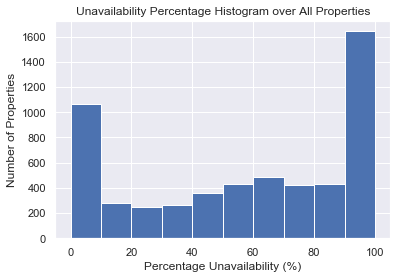

In [733]:
fig,ax=plt.subplots()
avail_percentage.unavailable_percent.plot(kind='hist')
# ax.title('Test')

ax.set_xlabel('Percentage Unavailability (%)')
ax.set_ylabel('Number of Properties')
# ax.set_ylabel('Ephemeral Tweets Sent',fontsize=16)
plt.title('Unavailability Percentage Histogram over All Properties')
ax.grid(True)

In [745]:
data_rev.head()

,scraping_id,scraped_date,date,price,available,available_sum,available_count,prices,availability_states,was_occupied,revenue,potential_revenue
0,2,2018-04-30,2018-04-01,250,True,46.0,46,[250],[True],False,0,0
1,2,2018-04-30,2018-04-02,115,False,15.0,46,[115],"[True, False]",True,115,115
2,2,2018-04-30,2018-04-03,115,True,46.0,46,[115],[True],False,0,0
3,2,2018-04-30,2018-04-04,115,True,46.0,46,[115],[True],False,0,0
4,2,2018-04-30,2018-04-05,145,False,0.0,46,"[150, 145]",[False],False,0,145


In [756]:
book_over_time = data_rev.groupby('date').available.count().reset_index().merge(
    data_rev.groupby('date').available.sum().reset_index(),
    how = 'left',
    on = 'date'
)

book_over_time.columns = ['date','total_units','units_available']
book_over_time.head()

,date,total_units,units_available
0,2018-04-01,4419,1711.0
1,2018-04-02,4419,1721.0
2,2018-04-03,4419,1717.0
3,2018-04-04,4419,1666.0
4,2018-04-05,4419,1522.0


In [757]:
book_over_time['units_unavailable'] = book_over_time.total_units-book_over_time.units_available

In [760]:
book_over_time['percent_unavail'] = book_over_time.units_unavailable/book_over_time.total_units

Text(0, 0.5, 'Proportion of Total Units Unavailable')

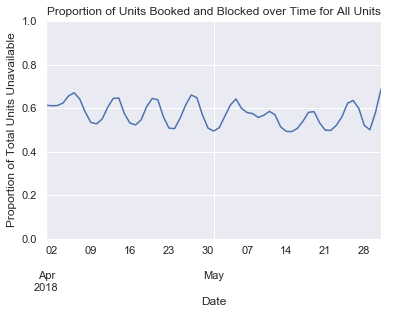

In [772]:
fig,ax = plt.subplots()
book_over_time.set_index('date')['percent_unavail'].plot()
ax.grid(True)

ax.set_title('Proportion of Units Booked and Blocked over Time for All Units')
ax.set_ylim([0,1])
ax.set_xlabel('Date')
ax.set_ylabel('Proportion of Total Units Unavailable')